# Alignment and analysis of single-cell RNA-seq data

The kallisto, bustools and kb-python programs are free, open-source software tools for performing this analysis that together can produce gene expression quantification from raw sequencing reads. In this tutorial, we pre-processed the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with kallisto and bustools, and then performed an basic analysis.

We made an improvement in integrating the kallisto, bustools and kb-python program in OmicVerse:

* **More user-friendly function implementation**： we automated their encapsulation into the ```omicverse.alignment``` class.

If you found this tutorial helpful, please cite kb-python and OmicVerse:

* Sullivan, D.K., Min, K.H.(., Hjörleifsson, K.E. et al. kallisto, bustools and kb-python for quantifying bulk, single-cell and single-nucleus RNA-seq. Nature Protocol (2025).
https://doi.org/10.1038/s41596-024-01057-0

* Melsted, P., Booeshaghi, A.S., Liu, L. et al. Modular, efficient and constant-memory single-cell RNA-seq preprocessing. Nature Biotechnology (2021). https://doi.org/10.1038/s41587-021-00870-2

In [26]:
import omicverse as ov
import scanpy as sc
import pandas as pd
import numpy as np
ov.plot_set()

🔬 Starting plot initialization...
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 8
    • [CUDA 0] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 1] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 2] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 3] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 4] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 5] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 6] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9
    • [CUDA 7] NVIDIA GeForce RTX 4090 D
      Memory: 23.6 GB | Compute: 8.9

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                              

## Download human reference files and build the index
We build a human cDNA and intron index from the human genome and annotations provided by Ensembl.

In [ ]:
%%time
!wget -P pbmc_1k_v3 ftp://ftp.ensembl.org/pub/release-108/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
!wget -P pbmc_1k_v3 ftp://ftp.ensembl.org/pub/release-108/gtf/homo_sapiens/Homo_sapiens.GRCh38.108.gtf.gz

In [2]:
ov.alignment.ref(
  fasta_paths='pbmc_1k_v3/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz',  #input
  gtf_paths='pbmc_1k_v3/Homo_sapiens.GRCh38.108.gtf.gz', #input
  index_path='pbmc_1k_v3/index.idx', #output
  t2g_path='pbmc_1k_v3/t2g.txt', #output
  cdna_path='pbmc_1k_v3/cdna.fa', #output
)

INFO:omicverse.alignment.kb_api:Starting ref workflow: standard
INFO:omicverse.alignment.kb_api:Executing standard workflow
[2025-10-22 05:12:17,269]    INFO [ref] Preparing pbmc_1k_v3/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz, pbmc_1k_v3/Homo_sapiens.GRCh38.108.gtf.gz
[2025-10-22 05:13:23,047]    INFO [ref] Splitting genome pbmc_1k_v3/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz into cDNA at /data/hulei/Projects/Omicverse_2/omicverse_update/tmp/tmpnl4h6b3g
[2025-10-22 05:14:46,566]    INFO [ref] Concatenating 1 cDNAs to pbmc_1k_v3/cdna.fa
[2025-10-22 05:14:51,118]    INFO [ref] Creating transcript-to-gene mapping at pbmc_1k_v3/t2g.txt
[2025-10-22 05:14:57,080]    INFO [ref] Indexing pbmc_1k_v3/cdna.fa to pbmc_1k_v3/index.idx
INFO:omicverse.alignment.kb_api:ref workflow completed!


{'cdna_fasta': 'pbmc_1k_v3/cdna.fa',
 't2g': 'pbmc_1k_v3/t2g.txt',
 'index': 'pbmc_1k_v3/index.idx',
 'workflow': 'standard',
 'technology': 'N/A',
 'parameters': {'threads': 8,
  'k': None,
  'overwrite': False,
  'workflow_type': 'standard'}}

## Generate RNA count matrices
The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store Anndata objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the ```index_path``` and ```t2g_path``` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v3 Chemistry, the technology ```10xv3``` argument is used.



In [3]:
ov.alignment.count(
    fastq_paths=['pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz', #input
                 'pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz', #input
                 'pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz', #input
                 'pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz'], #input
    index_path='pbmc_1k_v3/index.idx', #input
    t2g_path='pbmc_1k_v3/t2g.txt', #input
    technology='10XV3', # technology
    output_path='pbmc_1k_v3', #output
    h5ad=True,
    filter_barcodes=True,
    threads=2
)

INFO:omicverse.alignment.kb_api:Starting count workflow: standard
INFO:omicverse.alignment.kb_api:Technology: 10XV3
INFO:omicverse.alignment.kb_api:Output directory: pbmc_1k_v3
INFO:omicverse.alignment.kb_api:Executing standard workflow
[2025-10-22 05:17:06,836]    INFO [count] Using index pbmc_1k_v3/index.idx to generate BUS file to pbmc_1k_v3 from
[2025-10-22 05:17:06,837]    INFO [count]         pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
[2025-10-22 05:17:06,838]    INFO [count]         pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
[2025-10-22 05:17:06,838]    INFO [count]         pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
[2025-10-22 05:17:06,839]    INFO [count]         pbmc_1k_v3/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
[2025-10-22 05:30:42,678]    INFO [count] Sorting BUS file pbmc_1k_v3/output.bus to tmp/output.s.bus
[2025-10-22 05:30:53,699]    INFO [count] On-list not provided
[2025-10-22 05:30:53,700]   

{'workflow': 'standard',
 'technology': '10XV3',
 'output_path': 'pbmc_1k_v3',
 'parameters': {'threads': 2,
  'memory': '2G',
  'filter_barcodes': True,
  'h5ad': True,
  'loom': False,
  'cellranger': False,
  'tcc': False,
  'mm': False},
 'unfiltered': {'bus': 'pbmc_1k_v3/output.bus',
  'ecmap': 'pbmc_1k_v3/matrix.ec',
  'txnames': 'pbmc_1k_v3/transcripts.txt',
  'info': 'pbmc_1k_v3/run_info.json',
  'whitelist': 'pbmc_1k_v3/10x_version3_whitelist.txt',
  'inspect': 'pbmc_1k_v3/inspect.json',
  'bus_scs': 'pbmc_1k_v3/output.unfiltered.bus',
  'mtx': 'pbmc_1k_v3/counts_unfiltered/cells_x_genes.mtx',
  'genes': 'pbmc_1k_v3/counts_unfiltered/cells_x_genes.genes.txt',
  'barcodes': 'pbmc_1k_v3/counts_unfiltered/cells_x_genes.barcodes.txt',
  'genenames': 'pbmc_1k_v3/counts_unfiltered/cells_x_genes.genes.names.txt',
  'h5ad': 'pbmc_1k_v3/counts_unfiltered/adata.h5ad'},
 'filtered': {'whitelist': 'pbmc_1k_v3/filter_barcodes.txt',
  'bus_scs': 'pbmc_1k_v3/output.filtered.bus',
  'mtx': 'p

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by kb count into Python and analyse them using the omicverse pipeline.

You can find detailed information about these codes in this [website](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess_cpu).


In [16]:
adata = sc.read_h5ad("pbmc_1k_v3/counts_filtered/adata.h5ad")
var_names = pd.read_csv("pbmc_1k_v3/counts_filtered/cells_x_genes.genes.names.txt",
                        index_col=[0],header=None)
adata.var_names = var_names.index.tolist()
adata

AnnData object with n_obs × n_vars = 1198 × 62703

In [17]:
%%time
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
               doublets_method='scrublet',
              batch_key=None)
adata

🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics
   Mitochondrial genes (prefix 'MT-'): 37 found
   ✓ QC metrics calculated:
     • Mean nUMIs: 8708 (range: 858-62485)
     • Mean genes: 2658 (range: 23-8000)
     • Mean mitochondrial %: 12.8% (max: 98.2%)
   📈 Original cell count: 1,198

🔧 Step 2: Quality Filtering (SEURAT)
   Thresholds: mito≤0.2, nUMIs≥500, genes≥250
   📊 Seurat Filter Results:
     • nUMIs filter (≥500): 0 cells failed (0.0%)
     • Genes filter (≥250): 17 cells failed (1.4%)
     • Mitochondrial filter (≤0.2): 74 cells failed (6.2%)
   ✓ Filters applied successfully
   ✓ Combined QC filters: 74 cells removed (6.2%)

🎯 Step 3: Final Filtering
   Parameters: min_genes=200, min_cells=3
   Ratios: max_genes_ratio=1, max_cells_ratio=1
   ✓ Final filtering: 0 cells, 37,463 genes removed

🔍 Step 4: Doublet Detection
   ⚠️  Note: 'scrublet' detection is too old and may not work properly
   💡 Consider using 'doublets_method=sccomposite' for better results
   🔍

AnnData object with n_obs × n_vars = 1114 × 25240
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU'

In [18]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,
                       target_sum=50*1e4)
adata

🔍 [2025-10-22 07:16:17] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 25240/25240 genes are kept.
    Among 25240 genes, 25240 genes are robust.
✅ Robust gene identification completed successfully.
Begin size normalization: shiftlog and HVGs selection pearson

🔍 Count Normalization:
   Target sum: 500000.0
   Exclude highly expressed: True
   Max fraction threshold: 0.2
   ⚠️ Excluding 1 highly-expressed genes from normalization computation
   Excluded genes: ['IGKC']

✅ Count Normalization Completed Successfully!
   ✓ Processed: 1,114 cells × 25,240 genes
   ✓ Runtime: 0.24s

🔍 Highly Variable Genes Selection (Experimental):
   Method: pearson_residuals
   Target genes: 2,000
   Theta (overdispersion): 100

✅ Experimental HVG Selection Completed Successfully!
   ✓ Selected: 2,000 highly variable genes out of 25,240 total (7.9%)
   ✓ Results added to AnnData object:
     • 'highly_variable': Boolean vector (adata.var)
     • 'highly_varia

AnnData object with n_obs × n_vars = 1114 × 25240
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg'
    layers: 'counts'

In [19]:
%%time
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

CPU times: user 5.96 ms, sys: 0 ns, total: 5.96 ms
Wall time: 5.29 ms


View of AnnData object with n_obs × n_vars = 1114 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg'
    layers: 'counts'

In [22]:
%%time
ov.pp.scale(adata)
adata

CPU times: user 1.82 s, sys: 1.29 s, total: 3.11 s
Wall time: 685 ms


AnnData object with n_obs × n_vars = 1114 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg'
    layers: 'counts', 'scaled'

In [23]:
%%time
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

   🖥️ sklearn PCA backend: CPU computation
CPU times: user 7.38 s, sys: 26.5 s, total: 33.9 s
Wall time: 738 ms


AnnData object with n_obs × n_vars = 1114 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled'

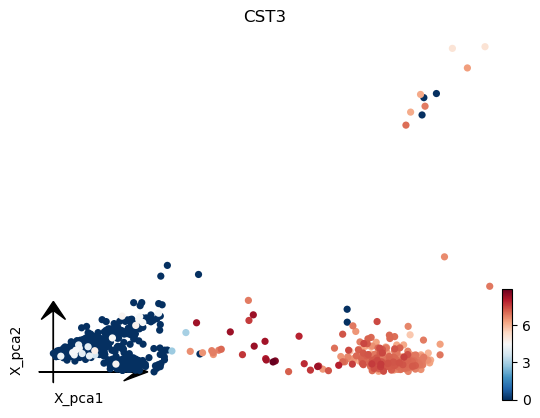

In [24]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']
ov.pl.embedding(adata,
                  basis='X_pca',
                  color='CST3',
                  frameon='small')